In [23]:
import numpy as np
from numpy import linalg
import cvxopt
from cvxopt import matrix, solvers
import pylab as pl

In [37]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

class SVM(object):
    
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        #gram matrix
        
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])
        
        P = matrix(np.outer(y,y)*K)
        q = matrix(np.ones(n_samples)*-1)
        A = matrix(y, (1, n_samples))
        b = matrix(0.0)
        
        if self.C is None:
            G = matrix(np.diag(np.ones(n_samples)*-1))
            h = matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples)*-1)
            tmp2 = np.identity(n_samples)
            G = matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = matrix(np.hstack((tmp1, tmp2)))
        
        #solve QP problem
        solution = solvers.qp(P,q,G,h,A,b)
        
        #Lagrange multipliers
        a = np.ravel(solution['x'])
        
        #support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        
        print("%d support vectors out of %d points" % (len(self.a), n_samples))
        
        #Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a*self.sv_y*K[ind[n], sv])
        self.b /= len(self.a)
        
        #weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
        
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w)+self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a*sv_y*self.kernel(X[i], sv)
                
                y_predict[i] = s
            return y_predict + self.b
    def predict(self, X):
        return np.sign(self.project(X))

In [38]:
def gen_linear_separable_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

def plot_margin(X1_train, X2_train, clf):
    def f(x, w, b, c=0):
    # given x, return y such that [x,y] in on the line
    # w.x + b = c
        return (-w[0] * x - b + c) / w[1]

    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    # w.x + b = 0
    a0 = -4; a1 = f(a0, clf.w, clf.b)
    b0 = 4; b1 = f(b0, clf.w, clf.b)
    pl.plot([a0,b0], [a1,b1], "k")

    # w.x + b = 1
    a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
    pl.plot([a0,b0], [a1,b1], "k--")

    # w.x + b = -1
    a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
    pl.plot([a0,b0], [a1,b1], "k--")

    pl.axis("tight")
    pl.show()

    
def plot_contour(X1_train, X2_train, clf):
    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.project(X).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    pl.show()

In [39]:
def test_linear():
    X1, y1, X2, y2 = gen_linear_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)
    
    clf = SVM()
    clf.fit(X_train, y_train)
    

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print ("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

     pcost       dcost       gap    pres   dres
 0: -1.5330e+01 -2.8768e+01  5e+02  2e+01  2e+00
 1: -1.6495e+01 -1.1426e+01  2e+02  7e+00  6e-01
 2: -2.5178e+01 -1.1983e+01  1e+02  4e+00  3e-01
 3: -8.5601e+00 -4.6583e+00  1e+01  4e-01  3e-02
 4: -3.4271e+00 -3.9133e+00  5e-01  1e-15  7e-15
 5: -3.7278e+00 -3.7333e+00  5e-03  1e-15  4e-15
 6: -3.7314e+00 -3.7315e+00  5e-05  3e-15  4e-15
 7: -3.7315e+00 -3.7315e+00  5e-07  1e-15  4e-15
Optimal solution found.
3 support vectors out of 180 points
20 out of 20 predictions correct


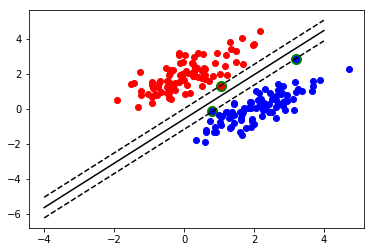

In [40]:
test_linear()